> Họ và tên: Phùng Dũng Quân\
> MSSV: 22280073

# Thư viện

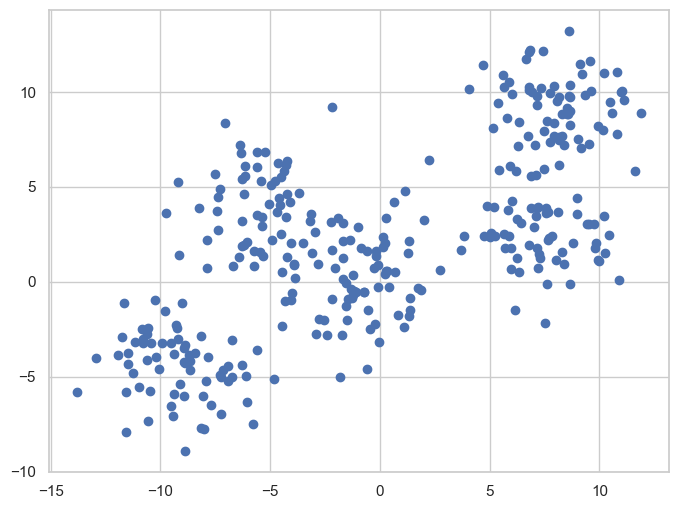

In [320]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from numpy import random
from pandas import DataFrame
from sklearn.cluster import KMeans

random.seed(234)
x, _ = make_blobs(n_samples=330, centers=5, cluster_std=1.84)
plt.figure(figsize=(8, 6))
plt.scatter(x[:,0], x[:,1])
plt.show()

In [321]:
gm = GaussianMixture(n_components=5).fit(x)
centers = gm.means_
print(centers)

[[-5.55836831  3.87299888]
 [ 7.28418475  2.56387124]
 [-0.90246061  0.16230294]
 [-9.18288987 -4.47852917]
 [ 8.11454324  9.24741885]]


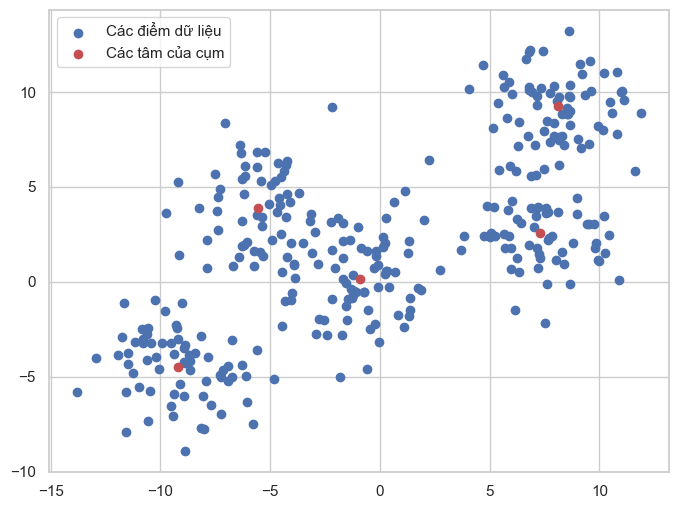

In [322]:
plt.figure(figsize=(8, 6))
plt.scatter(x[:,0], x[:,1], label="Các điểm dữ liệu")
plt.scatter(centers[:,0], centers[:,1], c='r', label="Các tâm của cụm")
plt.legend()
plt.show()

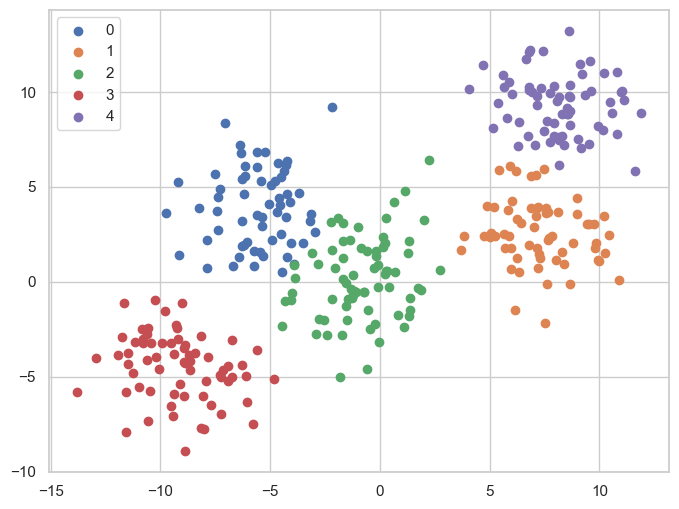

In [323]:
pred = gm.predict(x)

df = DataFrame({'x': x[:,0], 'y': x[:,1], 'label': pred})
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(8, 6))
for name, group in groups:
    ax.scatter(group.x, group.y, label=name)

ax.legend()
plt.show()

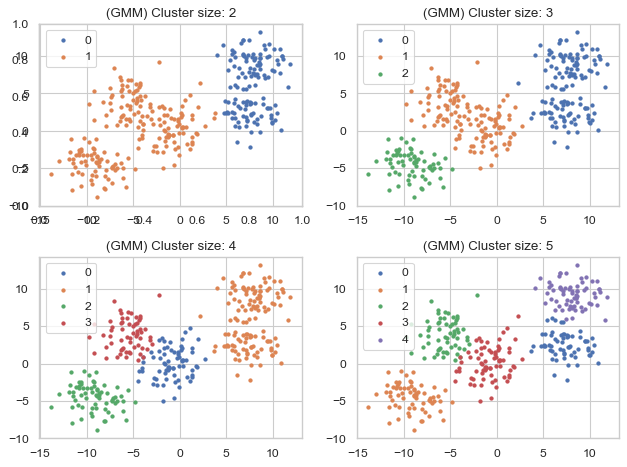

In [324]:
f = plt.figure(figsize=(8, 6), dpi=80)
f.add_subplot(2, 2, 1)

for i in range(2, 6):
    gm = GaussianMixture(n_components=i).fit(x)
    pred = gm.predict(x)
    df = DataFrame({'x': x[:,0], 'y': x[:,1], 'label': pred})
    groups = df.groupby('label')
    f.add_subplot(2, 2, i-1)
    for name, group in groups:
        plt.scatter(group.x, group.y, label=name, s=8)
    plt.title("(GMM) Cluster size: " + str(i))
    plt.legend()

plt.tight_layout()
plt.show()

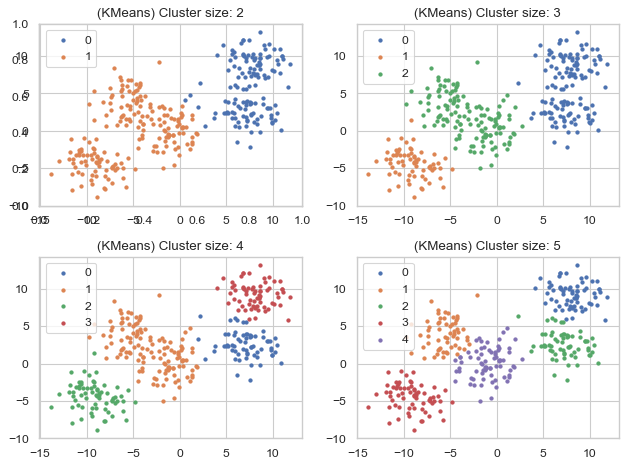

In [325]:
f = plt.figure(figsize=(8, 6), dpi=80)
f.add_subplot(2, 2, 1)

for i in range(2, 6):
    km = KMeans(n_clusters=i).fit(x)
    pred = km.predict(x)
    df = DataFrame({'x': x[:,0], 'y': x[:,1], 'label': pred})
    groups = df.groupby('label')
    f.add_subplot(2, 2, i-1)
    for name, group in groups:
        plt.scatter(group.x, group.y, label=name, s=8)
    plt.title("(KMeans) Cluster size: " + str(i))
    plt.legend()

plt.tight_layout()
plt.show()

# Thuật toán tự viết

In [326]:
import numpy as np

In [ ]:
class Mahalanobis:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.centroids = None
        self.labels = None

    # Hàm khởi tạo tâm cụm
    def initialize_centroids(self, x):
        initial_indices = np.random.choice(x.shape[0], self.n_clusters, replace=False)
        return x[initial_indices]

    # Hàm tính khoảng cách Mahalanobis   
    def mahalanobis_distance(self, x, mu, cov):
        distances = []
        for i in range(self.n_clusters):
            delta = x - mu[i]  # (n_samples, n_features)
            inv_cov = np.linalg.inv(cov[i])  # (n_features, n_features)

            # Tính khoảng cách cho từng điểm đến tâm cụm thứ i
            d = []
            for j in range(x.shape[0]):
                diff = delta[j].reshape(1, -1)  # (1, n_features)
                dist = np.sqrt((diff @ inv_cov @ diff.T)[0, 0])
                d.append(dist)
            distances.append(d)
        return np.array(distances).T
    
    # Hàm fit cho mô hình
    def fit(self, X):
        # 1. Khởi tạo tâm cụm
        self.centroids = self.initialize_centroids(X)
        iteration = 0
        while True:
            # 2. Tính ma trận hiệp phương sai cho từng cụm
            covariance_matrix = []
            for i in range(self.n_clusters):
                if iteration == 0:
                    # Lần đầu dùng toàn bộ dữ liệu để ước lượng
                    cov = np.cov(X.T)
                else:
                    # Các lần sau dùng điểm trong cụm
                    cluster_points = X[self.labels == i]
                    cov = np.cov(cluster_points.T)
                covariance_matrix.append(cov)
            
            # 3. Tính khoảng cách Mahalanobis và gán nhãn
            distances = self.mahalanobis_distance(X, self.centroids, covariance_matrix)
            new_labels = np.argmin(distances, axis=1)
            self.labels = new_labels
            
            # 4. Cập nhật tâm cụm mới
            new_centroids = np.zeros_like(self.centroids)
            for i in range(self.n_clusters):
                if np.sum(self.labels == i) > 0:
                    new_centroids[i] = X[self.labels == i].mean(axis=0)
                else:
                    new_centroids[i] = self.centroids[i]

            # 5. Kiểm tra điều kiện dừng
            if np.all(self.centroids == new_centroids):
                break
            
            self.centroids = new_centroids
            iteration += 1
        return self
    
    # Hàm dự đoán nhãn cho dữ liệu mới
    def predict(self, X):
        distances = self.mahalanobis_distance(X, self.centroids, [np.cov(X.T)] * self.n_clusters)
        return np.argmin(distances, axis=1)

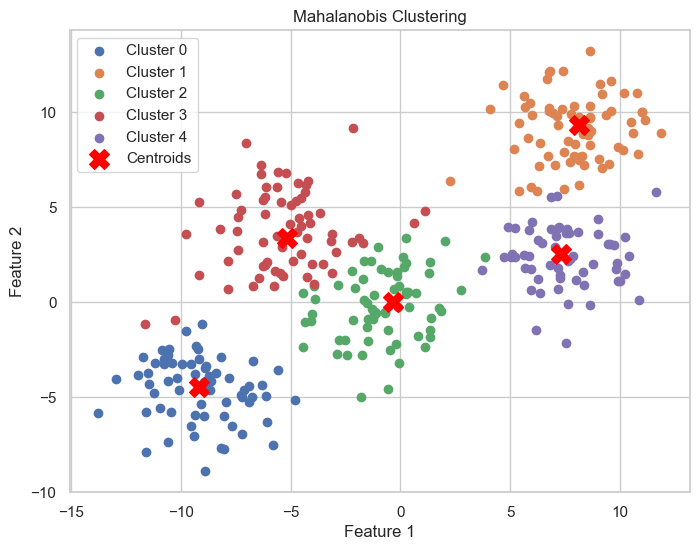

In [396]:
# Fit model
mahalanobis = Mahalanobis(5)
mahalanobis.fit(x)
pred = mahalanobis.predict(x)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
for i in range(mahalanobis.n_clusters):
    plt.scatter(x[pred == i, 0], x[pred == i, 1], label=f'Cluster {i}')
plt.scatter(mahalanobis.centroids[:, 0], mahalanobis.centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('Mahalanobis Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

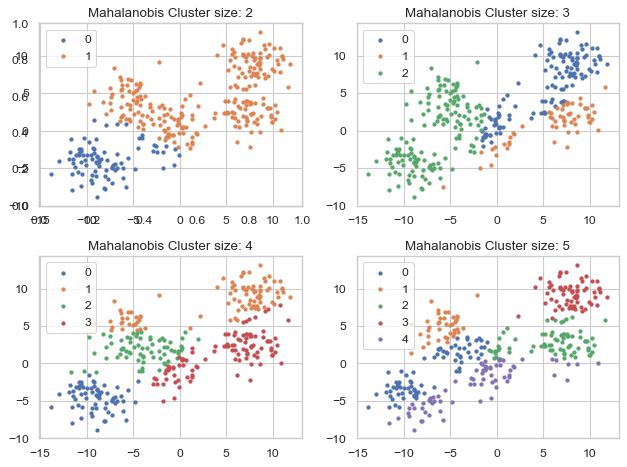

In [329]:
f = plt.figure(figsize=(8, 6), dpi=80)
f.add_subplot(2, 2, 1)

for i in range(2, 6):
    model = Mahalanobis(i).fit(x)
    pred = model.predict(x)
    df = DataFrame({'x': x[:,0], 'y': x[:,1], 'label': pred})
    groups = df.groupby('label')
    f.add_subplot(2, 2, i-1)
    for name, group in groups:
        plt.scatter(group.x, group.y, label=name, s=8)
    plt.title("Mahalanobis Cluster size: " + str(i))
    plt.legend()

plt.tight_layout()
plt.show()